**Японская литература и переводы**

В течение почти века японская литература как бы замерла. После блестящего времени прозы Ихара Сайкаку, стихов Басё и пьес Тикамацу Мондзаэмон наступила эпоха литературы "гэсаку", что можно перевести как сочинение для развлечения. Основными темами были: куртизанки, пуюличный дом, драмы о мести и воздаянии, адюльтер и тому подобное. Что говорить - этот период почти не переведен на русский язык (только 2 романа доступны - "Сливовый календарь любви" и "На своих двоих по тракту Токкайдо"). Однако с начала реставрации Мэйдзи в Японию хлынула огромным потоком переводная литература. Многие отцы-основатели современной японской литературы признавались, что учились на лучших произведениях английской, французской и русской литератур. Более того, тогда активно переводили не только романы, но и критику. Фтабатэй Симэй выстраивал новую теорию романа, опираясь на работы Белинского, Добролюбова, Писарева, Герцена. Влияние на японскую литературу было сильным. Поэтому интересно узнать, насколько перекликаются переводы и оригинальные произведения. Подгоняли ли Чехова и Достоевского к японским реалиям (в том числе и литературным), как это дело на первых порах в середине 19 века? Или наоборот, японские писатели пытались подражать своим русским кумирам и писали о Японии, но "по-русски"? В этом заключается **цель моего небольшого исследования**. Кроме того, я также хотел бы примерить изученные нами методами для рассмотрения японских текстов. 

Импортируем необходимые библиотеки

In [1]:
from tqdm import tqdm
import os
import re
import pandas as pd
import stanza
stanza.download("ja")
nlp_stanza = stanza.Pipeline(lang="ja", processors="tokenize, pos, lemma, depparse, ner")
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px
import json
from gensim.models import LdaModel
from gensim import corpora

C:\Users\Алексей\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-24 14:51:05 INFO: Downloaded file to C:\Users\Алексей\stanza_resources\resources.json
2025-06-24 14:51:05 INFO: Downloading default packages for language: ja (Japanese) ...
2025-06-24 14:51:07 INFO: File exists: C:\Users\Алексей\stanza_resources\ja\default.zip
2025-06-24 14:51:10 INFO: Finished downloading models and saved to C:\Users\Алексей\stanza_resources
2025-06-24 14:51:10 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-06-24 14:51:11 INFO: Downloaded file to C:\Users\Алексей\stanza_r

Загрузим собранные мной два корпуса.

Первый - корпус переводов русской литературы второй половины 19 века на японский язык, выполненных, приблизительно, в то же время. 
50 текстов включают в себя произведения разной формы (рассказы, пьесы, романы) различных авторов (Гаршин В.М., Достоевский Ф.М., Короленко В.Г.,
Лесков Н.С., Сологуб Ф.К., Толстой Л.Н., Тургенев И.С., Чехов А.П.). Выборка обусловлена одним обстоятельством - наличие переводов в открытом доступе.

Второй - корпус повестей и романов японских авторов конца 19 - начала 20 веков, оказавших значительное влияние на историю японской литературы. В первую очередь, это произведения Идзуми Кёка, Мори Огай, Нацумэ Сосэки, Токутоми Рока, Фтабатэй Симэй. Их почти в два раза меньше, чем в первом корпусе (что объясняется жанровой составляющей).

Все источники/модели и коды будут выложены в соответствующем репозитории (ссылка) на гитхабе https://github.com/murasakigarasu/RusJapCorpus.

In [2]:
path = 'translate/'
corpus_tr = []
for filename in tqdm(os.listdir(path)):
    with open(path + filename, encoding='utf-8') as txt:
        text = txt.read()
        corpus_tr.append(text)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 122.01it/s]


In [3]:
print(len(corpus_tr))

50


In [4]:
path = 'japanese/'
corpus_jp = []
for filename in tqdm(os.listdir(path)):
    with open(path + filename, encoding='utf-8') as txt:
        text = txt.read()
        corpus_jp.append(text)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 99.18it/s]


In [5]:
print(len(corpus_jp))

26


Напишем функцию для предобрабаотки текста. Каждый шаг включает в себя одну операцию. Это сделано, во-первых, для наглядности, 
а, во-вторых, чтобы не запутаться. Японская кодировка значительно отличается от "общепринятой". Например, используются 
другие знаки перпинания. (「) - здесь, по сути, пробела нет; это отдельный знак. Более того, не следует удалять тире или дефисы, 
потому что они могут спутаться с иероглифом один (一) или знаком долготы слога в слоговой азбуке катакана. Учитывая особенности, создаем
универсальную функцию и применяем на наших корпусах.

In [10]:
def cleanizer(corpus):
    a1 = ''.join(corpus)
    a1 = re.sub(r'\n', ' ', a1)
    a1 = re.sub(r'[A-Za-z]', '', a1)
    a1 = re.sub(r'\d', '', a1)
    a1 = re.sub(r'\.', '', a1)
    a1 = re.sub(r'（', '', a1)
    a1 = re.sub(r'）', '', a1)
    a1 = re.sub(r'…', '', a1)
    a1 = re.sub(r'？', '', a1)
    a1 = re.sub(r'！', '', a1)
    a1 = re.sub(r'「', '', a1)
    a1 = re.sub(r'」', '', a1)
    a1 = re.sub(r'\u3000', '', a1)
    clean_corpus = re.sub(r'※', '', a1)
    return clean_corpus

In [11]:
clean_corpus_tr = cleanizer(corpus_tr)
clean_corpus_tr[:100]

'ね、馭者ぎょしゃをやって見てもいいでしょう。私、馭者のとこへ行くわとソフィヤ・リヴォヴナが声高こわだかに言った、馭者さん、待ってよ。私、あんたの隣へ行くから。 彼女が橇そりの中で起たちあがると、夫のヴ'

In [12]:
clean_corpus_jp = cleanizer(corpus_jp)
clean_corpus_jp[:100]

'一  私は今年ことし三十九になる。人世じんせい五十が通相場とおりそうばなら、まだ今日明日きょうあす穴へ入ろうとも思わぬが、しかし未来は長いようでも短いものだ。過去って了えば実に呆気あッけない。まだまだ'

В качестве морфологического анализатора испольузем stanza. Несмотря на продолжительность работы, она показывает относительно неплохие
результаты. Более того, это одна из немногих библиотек, поддерживающих японский язык. NLTK, например, не работает с японским.

In [13]:
corp_doc_tr = nlp_stanza(clean_corpus_tr)
corp_doc_jp = nlp_stanza(clean_corpus_jp)

In [14]:
def stanza_to_df(corp_doc):
    list_of_rows = []
    counter = 0
    for sentence in corp_doc.sentences:
        counter += 1
        for word in sentence.words:
            list_of_rows.append([counter, word.id, word.text, word.upos, word.deprel, word.head, sentence.words[word.head-1].text])

    df_sentence = pd.DataFrame(list_of_rows, columns=['sent_id', 'id', 'token', 'pos', 'synt_tag', 'head_id', 'head_tok'])
    return df_sentence

In [15]:
df_translate = stanza_to_df(corp_doc_tr)
df_translate[:10]

,sent_id,id,token,pos,synt_tag,head_id,head_tok
0,1,1,ね,CCONJ,cc,8,見
1,1,2,、,PUNCT,punct,1,ね
2,1,3,馭者,NOUN,compound,4,ぎょしゃ
3,1,4,ぎょしゃ,NOUN,obj,6,やっ
4,1,5,を,ADP,case,4,ぎょしゃ
5,1,6,やっ,VERB,advcl,8,見
6,1,7,て,SCONJ,mark,6,やっ
7,1,8,見,VERB,root,0,。
8,1,9,て,SCONJ,mark,8,見
9,1,10,も,ADP,fixed,9,て


In [16]:
df_japanese = stanza_to_df(corp_doc_jp)
df_japanese[:10]

,sent_id,id,token,pos,synt_tag,head_id,head_tok
0,1,1,一,NUM,nummod,2,私
1,1,2,私,PRON,nsubj,10,なる
2,1,3,は,ADP,case,2,私
3,1,4,今年,NOUN,compound,5,こと
4,1,5,こと,NOUN,obl,10,なる
5,1,6,し,AUX,aux,5,こと
6,1,7,三十,NUM,nummod,8,九
7,1,8,九,NUM,obl,10,なる
8,1,9,に,ADP,case,8,九
9,1,10,なる,VERB,root,0,。


In [18]:
df_translate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548549 entries, 0 to 1548548
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   sent_id   1548549 non-null  int64 
 1   id        1548549 non-null  int64 
 2   token     1548549 non-null  object
 3   pos       1548549 non-null  object
 4   synt_tag  1548549 non-null  object
 5   head_id   1548549 non-null  int64 
 6   head_tok  1548549 non-null  object
dtypes: int64(3), object(4)
memory usage: 82.7+ MB


In [19]:
df_japanese.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638630 entries, 0 to 1638629
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   sent_id   1638630 non-null  int64 
 1   id        1638630 non-null  int64 
 2   token     1638630 non-null  object
 3   pos       1638630 non-null  object
 4   synt_tag  1638630 non-null  object
 5   head_id   1638630 non-null  int64 
 6   head_tok  1638630 non-null  object
dtypes: int64(3), object(4)
memory usage: 87.5+ MB


У нас приблизительно одинаковое количество токенов: 1,5 миллиона и 1,6 миллион! Попробуем избавиться от знаков пунктуации, 
другими словами от точек.

In [20]:
df_tr_clean = df_translate.loc[(df_translate['synt_tag'] != 'punct')]
df_tr_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1388211 entries, 0 to 1548547
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   sent_id   1388211 non-null  int64 
 1   id        1388211 non-null  int64 
 2   token     1388211 non-null  object
 3   pos       1388211 non-null  object
 4   synt_tag  1388211 non-null  object
 5   head_id   1388211 non-null  int64 
 6   head_tok  1388211 non-null  object
dtypes: int64(3), object(4)
memory usage: 84.7+ MB


In [21]:
df_jap_clean = df_japanese.loc[(df_japanese['synt_tag'] != 'punct')]
df_jap_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1492636 entries, 0 to 1638629
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   sent_id   1492636 non-null  int64 
 1   id        1492636 non-null  int64 
 2   token     1492636 non-null  object
 3   pos       1492636 non-null  object
 4   synt_tag  1492636 non-null  object
 5   head_id   1492636 non-null  int64 
 6   head_tok  1492636 non-null  object
dtypes: int64(3), object(4)
memory usage: 91.1+ MB


In [25]:
tokens_tr = df_tr_clean.get('token')
tokens_list_tr = tokens_tr.to_list()
print(len(set(tokens_list_tr)))

44540


In [26]:
tokens_jp = df_jap_clean.get('token')
tokens_list_jp = tokens_jp.to_list()
print(len(set(tokens_list_jp)))

70317


Число уникальных токенов больше в корпусе японской литературы, что выглядит вполне логично. 
Обучаем w2v-модели и сохраняем их.

In [27]:
w2v_tr = gensim.models.Word2Vec(tokens_list_tr, vector_size=300, window=5, min_count=2, sg=0, epochs=5) 

In [28]:
w2v_tr.wv.save_word2vec_format('translate.bin', binary=True) 

In [29]:
w2v_jp = gensim.models.Word2Vec(tokens_list_jp, vector_size=300, window=5, min_count=2, sg=0, epochs=5) 

In [30]:
w2v_jp.wv.save_word2vec_format('japanese.bin', binary=True) 

Попробуем визуализировать нашу модель, изобразив самые частотные токены. Интересно, скажут ли они нам о чём-то?
Для этого после отбора и векторизации снижаем их размерность методами К средних.

In [45]:
freq_tokens_tr = w2v_tr.wv.key_to_index  
words_tr = list(freq_tokens_tr.keys())[:500]
print(words_tr)

['の', 'た', 'い', 'し', 'な', 'て', 'と', 'に', 'っ', 'は', 'か', 'で', 'う', 'を', 'が', 'も', 'る', 'ん', 'ま', 'こ', 'ら', 'れ', 'あ', 'だ', 'り', 'そ', 'す', 'く', 'わ', 'ー', 'よ', 'き', 'さ', 'つ', 'お', 'け', 'え', 'ど', 'や', 'ち', 'ろ', '人', '彼', 'じ', 'め', '一', 'せ', 'リ', 'ば', 'み', 'ゃ', 'へ', 'ね', 'フ', 'ル', 'ヴ', 'ン', '見', '言', '出', '分', 'ず', '自', 'イ', 'ょ', 'ほ', '女', 'ス', '―', 'ャ', 'チ', '何', '思', '間', '行', '手', '気', '来', '・', 'ひ', 'げ', '子', 'ア', '時', 'ご', 'ロ', 'ニ', 'コ', 'ナ', 'シ', '今', '上', 'ラ', 'カ', '中', '前', 'ト', '事', '僕', 'び', 'ふ', 'ド', 'ィ', '二', '立', '方', 'べ', '心', '大', '生', 'ぐ', 'ぶ', 'む', 'ざ', '日', '知', '話', 'ェ', 'ぎ', '目', '者', 'ッ', 'パ', 'レ', 'ワ', '考', '持', 'ぬ', '男', 'ョ', 'マ', '家', '口', '身', '顔', '合', 'ジ', '君', '物', 'ミ', '意', '々', '同', '下', '聞', 'ク', '度', 'ぞ', 'ぜ', 'ノ', '当', '小', '十', '不', '私', '年', '屋', '長', '声', 'エ', 'テ', 'ぼ', '感', 'ヤ', '入', '笑', '的', '様', 'セ', '悪', 'キ', '本', '後', '明', 'ブ', '実', '向', '相', '無', '誰', 'ゆ', '金', '場', 'ゐ', '切', '引', 'づ', '三', '部', 'ソ', '-', 'タ', '少', '愛', '頭', '通', '然', '足', '返', '眼',

In [48]:
word_vectors_tr = np.array([w2v_tr.wv[word] for word in words_tr])
word_vectors_tr

array([[ 0.1937547 ,  0.50140226, -0.28436127, ..., -0.02080423,
        -0.04620762, -0.22217722],
       [-0.01206438, -0.11295118,  0.01864262, ...,  0.23758872,
         0.3593409 ,  0.05644825],
       [ 0.6772859 , -0.00564417, -0.1034717 , ...,  0.6875965 ,
        -0.07396491, -0.11741587],
       ...,
       [-0.09511542,  0.20732217, -0.15333875, ..., -0.04128012,
        -0.00544072, -0.2418253 ],
       [-0.16280748, -0.04445959,  0.18609482, ..., -0.36926097,
         0.03414308,  0.07406033],
       [ 0.16024649,  0.10274301, -0.2787939 , ...,  0.13142057,
         0.21806596, -0.15668516]], dtype=float32)

In [51]:
tsne = TSNE(n_components=2, random_state=17, perplexity=30, n_iter=1000)
tsne_vectors_tr = tsne.fit_transform(word_vectors_tr)
tsne_vectors_tr[:10]

C:\Users\Алексей\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


array([[ -4.398302,  12.953228],
       [-11.035936,  15.153592],
       [-12.56919 ,  16.725658],
       [-13.412839,  14.87543 ],
       [-10.004842,  14.908679],
       [-10.766718,  13.397343],
       [-10.509177,  17.91075 ],
       [ -8.290855,  12.608778],
       [-12.003421,  13.918314],
       [-10.483027,  13.824475]], dtype=float32)

In [53]:
n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=17)
clusters_tr = kmeans.fit_predict(word_vectors_tr)
print(clusters_tr)
print(len(clusters_tr))

[0 0 0 0 0 0 0 4 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 3 3 0 0 4 0 2 0 0 0 4 0 2 2 2 2 0 1 0 4 0 3 2 0 0 3 2 4 2 2 3 1 1
 4 4 4 4 3 0 0 3 2 3 0 2 2 2 2 2 4 4 2 2 3 3 2 3 3 0 0 2 2 3 4 3 0 3 4 4 0
 0 0 0 3 4 4 2 0 3 3 2 2 2 2 4 4 4 3 2 2 3 3 4 4 1 2 3 4 2 3 3 3 4 4 2 3 0
 4 2 4 4 3 3 3 3 3 3 3 2 2 0 4 2 4 1 3 3 2 3 2 3 3 4 2 3 4 3 3 3 0 3 3 4 4
 0 4 3 3 2 3 2 4 4 3 4 3 4 4 4 3 3 4 0 3 1 3 3 4 0 3 3 3 3 3 3 4 1 4 3 2 3
 3 3 3 3 3 3 2 4 0 3 3 1 4 3 4 3 3 4 3 3 4 3 3 4 3 4 2 2 3 2 4 3 3 3 2 4 2
 0 3 3 2 4 3 3 2 4 4 4 3 3 3 4 4 4 3 3 3 4 4 3 3 3 1 3 4 3 3 3 2 4 4 4 4 4
 3 3 2 3 2 4 3 3 4 3 2 3 4 4 4 3 2 4 2 3 3 4 3 4 3 3 4 3 3 3 3 3 4 4 4 3 3
 4 3 4 4 3 3 3 2 3 3 3 4 3 4 2 2 2 3 4 3 4 3 3 3 3 3 3 0 4 2 2 2 2 3 2 3 3
 3 3 3 3 3 4 4 3 3 3 4 3 3 3 3 3 4 3 3 2 3 3 3 3 3 1 3 4 3 3 3 3 3 3 2 3 3
 2 4 3 4 3 3 3 3 3 3 4 3 2 3 3 3 4 3 3 3 4 3 1 3 3 3 3 3 3 3 3 3 4 3 3 3 4
 4 3 3 3 3 3 3 3 3 3 4 4 4 3 3 3 4 3 3 3 4 4 3 3 3 3 3 3 3 0 2 4 3 1 4 3 3
 3 3 3 3 3 3 3 1 3 3 3 4 

In [59]:
plt.rcParams['font.family'] = "Arial Unicode MS"
#Это самая важная строчка кода при визуализии японских слов! Без указания шрифта Arial Unicode MS или других немногих, поодерживающих
#японскую иероглифику, слова отобразить будет невозможно! Проверено на собственном горьком опыте.

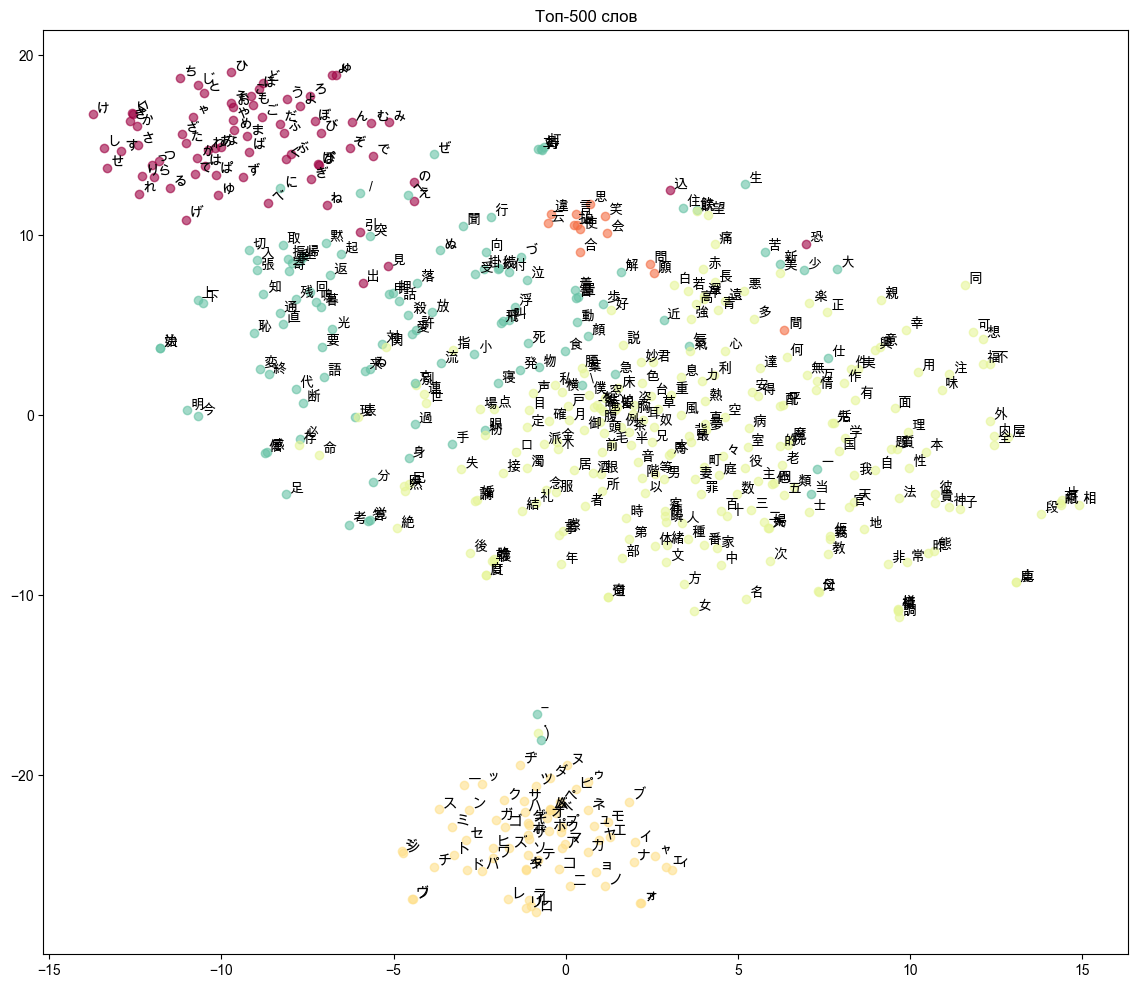

In [60]:
plt.figure(figsize=(14, 12))
for i, word in enumerate(words_tr):
    x, y = tsne_vectors_tr[i, :]
    plt.scatter(x, y, c=[plt.cm.Spectral(clusters_tr[i] / n_clusters)], marker='o', alpha=0.6)
    plt.text(x + 0.1, y + 0.1, word, fontsize=10)

plt.title("Топ-500 слов")
plt.show()

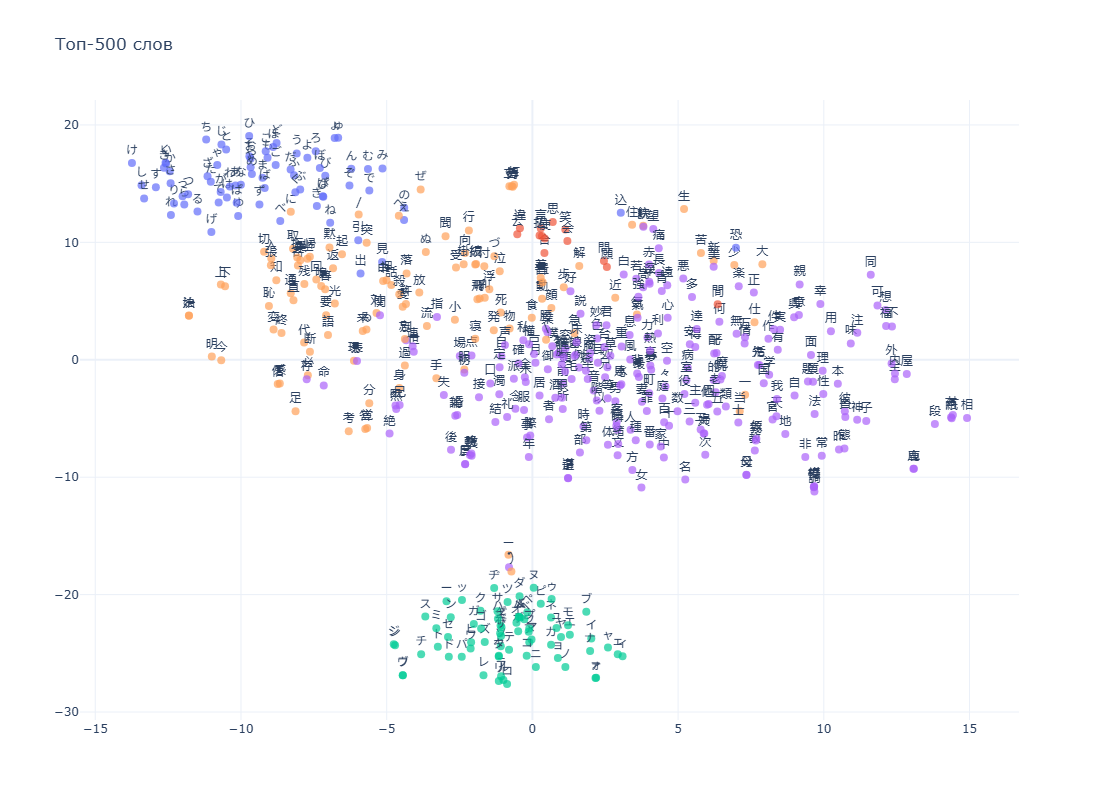

In [63]:
fig = go.Figure()
for i, word in enumerate(words_tr):
    x, y = tsne_vectors_tr[i, :]
    color = px.colors.qualitative.Plotly[clusters_tr[i] % len(px.colors.qualitative.Plotly)]
    fig.add_trace(
        go.Scatter(
            x=[x],
            y=[y],
            mode="markers+text",
            text=[word],
            textposition="top center",
            marker=dict(size=8, color=color, opacity=0.7),
            hovertemplate=f"Слово: {word}<br>Кластер: {clusters_tr[i]}<br>t-SNE 1: {x:.2f}<br>t-SNE 2: {y:.2f}"
        )
    )

fig.update_layout(
    title="Топ-500 слов",
    showlegend=False,
    hovermode="closest",
    width=1000,
    height=800,
    template="plotly_white"
)
fig.show()

На двух графиках четко выделяются несколько кластеров:
знаки слоговой азбуки хирагана, знаки слоговой азбуки катакана, глаголы гворения/суждения и всё остальное.
Обилие знаков слоговых азбук связано с осбенностями лемматизации японского текста. Традиционно ими прописывают грамматические 
(изменяющиеся) части слов. Поэтому все анализаторы их привыкли видеть отдельными токенами с POS = AUX. Приведу пример.
глагол "накормили" в японском языке будет записываться как 食べさせられた и при лемматизации распадется на 5 токенов:
食 (глагол) + べ (показатель спряжения) + させ (побудительный залог) + られ (страдательный залог) + た (прошедшее время).
Из-за этого искусственно увеличивается частота определенных токенов и групп.

Попробуем вытащить только существительные и визуализировать их.

In [72]:
tr_tok = df_tr_clean.loc[:, ['token', 'pos']]
corpus_tr_tagged = []
for index, row in tr_tok.iterrows():
    line = row['token'] + '_' + row['pos']
    corpus_tr_tagged.append(line)
    
corpus_tr_tagged[:10]

['ね_CCONJ',
 '馭者_NOUN',
 'ぎょしゃ_NOUN',
 'を_ADP',
 'やっ_VERB',
 'て_SCONJ',
 '見_VERB',
 'て_SCONJ',
 'も_ADP',
 'いい_AUX']

*Небольшой комментарий. Оставил эту ячейку с кодом, чтобы показать один из способов достать токены с тегами, а также их разметку. 
Глагол "смотреть" в уступительной форме 見ても как раз состоит из 3 отдельных токенов.*

In [112]:
noun_df_tr = df_tr_clean.loc[(df_tr_clean['pos'] == 'NOUN')]
nouns_tr = []
for index, row in noun_df_tr.iterrows():
    line = row['token']
    nouns_tr.append(line)

In [116]:
w2v_tr_noun = gensim.models.Word2Vec(words_nouns_tr, vector_size=300, window=5, min_count=2, sg=0, epochs=5) 

In [122]:
freq_nouns_tr = w2v_tr_noun.wv.key_to_index  
nouns_tr = list(freq_nouns_tr.keys())[:500]
print(nouns_tr)

['N', '_', 'O', 'U', 'と', 'こ', '人', 'お', 'ん', 'も', 'い', 'う', 'り', 'の', 'つ', 'ま', '自', 'ち', 'し', '分', 'き', 'さ', 'た', 'か', '間', 'ー', '手', '子', 'ろ', '気', '一', '時', 'わ', '中', '事', 'け', 'ら', 'め', 'み', 'え', '方', 'あ', 'よ', '女', 'な', 'じ', '者', '目', '心', 'く', '今', 'ご', 'ル', '上', '前', '日', 'ン', '男', 'ほ', '家', '顔', '身', '物', '話', 'れ', '口', 'ば', '生', 'や', '度', '屋', '声', '年', 'ょ', 'ふ', 'ト', '本', '後', 'ス', '金', '場', '意', 'っ', '部', '頭', '大', 'リ', '眼', '様', '地', '合', '当', 'フ', '父', '相', 'ひ', '小', '母', 'ア', 'カ', '下', '言', 'す', '長', '情', '神', 'そ', 'び', 'だ', '所', '世', 'ブ', '思', 'イ', 'せ', '二', '馬', '病', 'げ', 'ど', '道', '外', '名', '御', '先', '不', '供', '娘', '第', '想', '足', 'ド', '親', '理', '老', '無', '学', 'て', '持', 'ラ', 'ず', 'は', '会', 'ャ', '実', '悪', '々', '夫', '主', '仕', '同', 'シ', '面', '点', '色', 'ぎ', 'ッ', '力', 'ゅ', '感', '教', '違', 'べ', 'が', 'ぶ', 'ゃ', '片', '問', '体', '真', '水', '活', '夜', '行', '笑', '息', '音', '兄', '車', '調', '食', 'マ', 'ク', 'レ', '通', 'チ', 'テ', '代', '用', '最', '出', '妻', '胸', '両', 'ロ', '味', '庭', '婦', '愛', 'ざ',

In [123]:
noun_vectors_tr = np.array([w2v_tr_noun.wv[word] for word in nouns_tr])
noun_vectors_tr

array([[ 3.24175388e-01, -2.68280804e-01,  1.53018683e-01, ...,
         3.74805063e-01, -1.17544465e-01,  5.56624353e-01],
       [-2.09305510e-01,  6.09668195e-01, -7.97903657e-01, ...,
        -5.14358282e-01, -1.88189477e-01, -1.70680106e-01],
       [-4.31036472e-01,  9.99546647e-02,  9.11619127e-01, ...,
         4.72314298e-01, -2.32697353e-01, -1.86068624e-01],
       ...,
       [ 3.16775516e-02,  7.31229484e-02, -4.04452011e-02, ...,
        -4.78665493e-02, -3.43835354e-02,  5.85373268e-02],
       [-3.62403467e-02,  1.96374089e-01, -1.74107328e-01, ...,
        -7.01625366e-04,  1.93492323e-01, -1.03226334e-01],
       [-6.28522933e-02,  3.40436906e-01,  4.02189646e-04, ...,
        -3.58335793e-01,  1.64422676e-01, -4.44693789e-02]], dtype=float32)

In [127]:
tsne = TSNE(n_components=2, random_state=17, n_iter=1000)
tsne_vectors_tagged_tr = tsne.fit_transform(noun_vectors_tr)
n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=17)
clusters_tagged_tr = kmeans.fit_predict(noun_vectors_tr)
print(clusters_tagged_tr)
print(len(clusters_tagged_tr))

C:\Users\Алексей\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[2 2 2 4 3 3 0 3 3 3 3 3 3 3 3 3 0 3 3 0 3 3 3 3 0 1 0 0 3 0 0 0 3 0 0 3 3
 3 3 3 0 3 3 0 3 3 0 0 0 3 0 3 1 0 0 0 1 0 3 0 0 0 0 0 2 0 3 0 3 0 0 0 0 3
 2 1 0 0 1 0 0 0 2 0 0 4 1 0 0 0 0 0 1 0 0 3 4 0 1 1 0 0 3 0 4 0 3 2 2 0 0
 1 0 1 2 0 0 4 2 2 0 0 0 4 0 4 0 0 0 4 0 1 0 4 0 4 0 2 4 1 2 2 4 1 4 4 4 0
 4 4 4 1 4 0 0 2 1 4 2 4 4 0 2 2 2 2 4 4 4 4 4 0 4 4 0 4 4 0 4 4 4 1 1 1 4
 1 1 4 4 0 4 0 0 4 1 4 4 4 4 2 4 1 4 0 0 4 4 0 4 2 4 4 4 4 2 4 4 4 4 4 4 4
 4 4 4 1 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1 4 1 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 1 4 4 4 4 4 1 1 4 4 2 4 4 4 4 2 4 1 4 4 4 1 4 4 4 4 4 4 4 4 4
 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 1 4 4 4 4 4 4 2 1 4 2 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 1 4 1 4 4 1 1 2 4 4 4 1 4 4 2 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 1 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 1 4 4 4 4 4 4
 4 4 4 1 4 4 4 1 4 4 4 4 

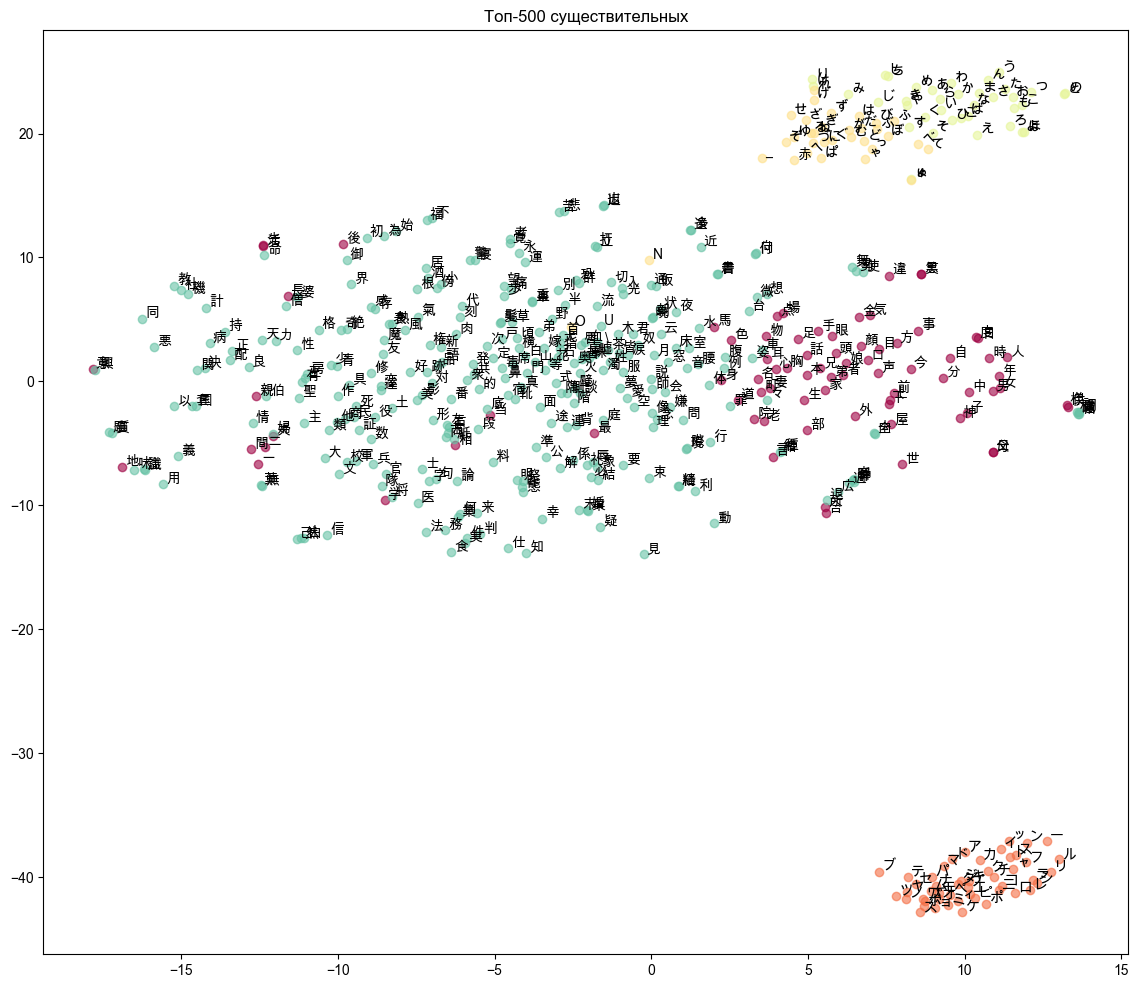

In [128]:
plt.figure(figsize=(14, 12))
for i, word in enumerate(nouns_tr):
    x, y = tsne_vectors_tagged_tr[i, :]
    plt.scatter(x, y, c=[plt.cm.Spectral(clusters_tagged_tr[i] / n_clusters)], marker='o', alpha=0.6)
    plt.text(x + 0.1, y + 0.1, word, fontsize=10)

plt.title("Топ-500 существительных")
plt.show()

Картина не улучшилась. Видно много ошибок, возникших при лемматизации. Несколько довольно частотных глаголов при разметке были определены как существительные. Кластеры остались плохо интерпретируемыми. Однако, благодаря теггированию по частям речи уменьшили частотность знаков слоговых азбук (но не избавились - увы!). 

Попробуем посмотреть по отдельным абстрактным понятиям.

In [200]:
print('Для корпуса переводов с русского языка: ', w2v_tr.wv.most_similar('愛', topn=10)) 
print('Для корпуса японских произведений: ', w2v_jp.wv.most_similar('愛', topn=10)) 

Для корпуса переводов с русского языка:  [('欲', 0.6500046253204346), ('捜', 0.6250594854354858), ('哀', 0.604052722454071), ('対', 0.592003345489502), ('貸', 0.5776901841163635), ('許', 0.5723320245742798), ('忙', 0.5718531012535095), ('嬉', 0.5704233050346375), ('憐', 0.5645872950553894), ('隠', 0.5604548454284668)]
Для корпуса японских произведений:  [('哀', 0.6887943148612976), ('怕', 0.6499479413032532), ('示', 0.6178314089775085), ('蝨', 0.6112471222877502), ('像', 0.6077470779418945), ('忙', 0.5935043692588806), ('皆', 0.5828244686126709), ('悲', 0.5725831389427185), ('憐', 0.5688161253929138), ('話', 0.5647525787353516)]


In [201]:
print('Для корпуса переводов с русского языка: ', w2v_tr.wv.most_similar('恋', topn=10)) 
print('Для корпуса японских произведений: ', w2v_jp.wv.most_similar('恋', topn=10)) 

Для корпуса переводов с русского языка:  [('嬌', 0.7151882648468018), ('寵', 0.6624305844306946), ('博', 0.6479086875915527), ('撫', 0.6354010701179504), ('想', 0.6115924119949341), ('宜', 0.6002185344696045), ('烈', 0.5965808629989624), ('呈', 0.590519368648529), ('可', 0.5885997414588928), ('界', 0.5879855155944824)]
Для корпуса японских произведений:  [('敗', 0.6506330370903015), ('可', 0.6444124579429626), ('嬌', 0.6411798000335693), ('敬', 0.6339746117591858), ('乞', 0.6330342292785645), ('想', 0.6267023682594299), ('嘲', 0.5920667052268982), ('議', 0.5902661085128784), ('批', 0.588617205619812), ('佳', 0.5836135149002075)]


Слово "любовь" в японском представлена, как минимум, 2 иероглифами: '愛' (ай) и '恋' (кой).
Для "ай":
И в переводах, и в японских произведениях любовь несёт налёт печали и меланхолии (哀, аварэ), жалости (憐, аварэ(му)). Однако "русская любовь" - это страсть (欲, ёку), из-за которой ловят/преследуют (捜, сасу), которая рождает противостояние (対, тай), которую скрывают (隠, какусу), но всё-таки позволяют (許, юрусу). Даже отображается, в какой-то мере, завязка истории - капитал/заём (貸, си).
"Японская любовь" немного другая. Это трагедия (悲, хи), символ (像, сё), который всем (皆, мина) показывают (示, симэсу), о которой говорят (話, ханасу). Она как вошь (蝨, сирами). Она пугает и заставляет волноваться (怕, осорэру).

Для "кой":
В обоих случаях подобная любовь пленительна (嬌, намамэкасии), возможна (可, ка). Она предмет для размышлений и мечтаний (想, омои). И в каком-то смысле противоречивы.
В переводах любовь благоволит (寵, мэгуму). Она резка и горяча (烈, рэцу), но при этом мудра (博, хаку). В ней есть степень (呈, ходо) и границы (界, кай).
Японские же авторы пишут о ней как объекте "победы-неудачи" (敗, хай). Её уважают (敬, уямару), но в тоже самое время критикуют (批, хи) и высмеивают (嘲, адзакэру). Однако любовь всё равно замечательна (佳, ёй).

Подводя итог, любовь всё-таки разная. Для русских авторов любовь побуждает, это мотив к активным действиям. Тогда как для японских писателей пассивны влюбленные. Не их сподвигает, а вместо них выполняют. Это соотностится, в принципе, с агентивностью японского языка (японцы скажут, скорее, не тьмой покрылись, а тьма покрыла). Более того, "японская любовь" трагична, порицаема и у всех на виду, в чём видно отголоски эпохи Токугава с любовными драмами и тотальным доносительством.

In [204]:
print('Для корпуса переводов с русского языка: ', w2v_tr.wv.most_similar('幸', topn=10)) 
print('Для корпуса японских произведений: ', w2v_jp.wv.most_similar('幸', topn=10)) 

Для корпуса переводов с русского языка:  [('祝', 0.952913224697113), ('裕', 0.906069278717041), ('祉', 0.9011752605438232), ('冥', 0.8068645000457764), ('覊', 0.8042890429496765), ('吉', 0.792948842048645), ('遜', 0.7858308553695679), ('省', 0.7836685180664062), ('憫', 0.7696093320846558), ('縹', 0.7692131996154785)]
Для корпуса японских произведений:  [('賽', 0.784597635269165), ('遑', 0.7343756556510925), ('審', 0.7287030816078186), ('圖', 0.7271637320518494), ('嘶', 0.6925479173660278), ('囁', 0.6920583844184875), ('祝', 0.6897879838943481), ('曝', 0.6843523383140564), ('矣', 0.6826421618461609), ('猿', 0.6767851114273071)]


Следующее абстрактное понятие - "счастье" (幸, сиавасэ).

Для переводов характерно видеть в счастье благославление/результат молитвы (祝, сюку/ивау) (для японских произведений это менее характерно, но то же присутствует. И несмотря на обилие разных синонимов: благососотояние (祉, си), обилие (裕, ю), веселье (吉, ёси) - здесь же слова потусторонний (冥, курай), горевать (憫, аварэму). Счастье - быстрый и радостный, но конечный миг.

Для японских авторов - это результат игры в кости (賽, сай). Оно связано с досугом (遑, хима). О нём следует шептать (囁, сасаяку). И в целом, достойно только обезьяны (猿, сару). Другими словами, счастье - что-то не очень потребное. Оно связано с другой стороной жизни. Правильному джентелмену не пристало об этом думать.

In [205]:
print('Для корпуса переводов с русского языка: ', w2v_tr.wv.most_similar('女', topn=10))
print('Для корпуса японских произведений: ', w2v_jp.wv.most_similar('女', topn=10))

Для корпуса переводов с русского языка:  [('奴', 0.5961815714836121), ('方', 0.5552572011947632), ('淫', 0.5551885962486267), ('春', 0.5490082502365112), ('雅', 0.5435977578163147), ('灰', 0.5321767926216125), ('此', 0.5285342335700989), ('尉', 0.5264176726341248), ('黒', 0.5196776390075684), ('疚', 0.5148715376853943)]
Для корпуса японских произведений:  [('爵', 0.5692974925041199), ('尉', 0.5683226585388184), ('奴', 0.5558647513389587), ('娘', 0.5337805151939392), ('眇', 0.5282424092292786), ('睦', 0.5266568660736084), ('猫', 0.5183998346328735), ('武', 0.5157689452171326), ('婿', 0.5153439044952393), ('竈', 0.5091857314109802)]


Отношение к женщинам различается в нашей культуре. Это отражается и на словах. 
В русских переводах акцент ставиться на распутстве (淫, мидара) и неприличности (сам иероглиф значит весна, но в этом контексте появляется его второе значение, связанное с амурными делами; 春, сюн) и виноватости (疚, ямасии). Скорее всего, это больше влияние произведений, используемых в выборке, чем что-то культурное. Зато можно немного реконструировать облик женщин: это изящные (雅, миябияка) блондинки (灰, хай (пепел; о цвете волосы - светлый)) или брюнетки (黒, куро (чёрный; о цвете волос - тёмный)).
В японских произведениях ображают внимание на социальный статус женщны. Чья она дочь (娘, мусумэ)? Кто её муж (婿, муко): аристократ (爵, сяку) или офицер (尉, и)? И самое главное - быть в хороших отношениях (睦, муцумадзии). Женщина сравнивается с кошкой (猫, нэко). Очевидно, европейское влияние, потому что традиционно кошки, хоть и воспринимались положительно (защитники буддийских сутр), считались оборотнями. Домашний уют и семейная жизнь стала ассоциироваться, видимо, только в период Мэйдзи.

In [206]:
print('Для корпуса переводов с русского языка: ', w2v_tr.wv.most_similar('神', topn=20))
print('Для корпуса японских произведений: ', w2v_jp.wv.most_similar('神', topn=20))

Для корпуса переводов с русского языка:  [('密', 0.8281508684158325), ('模', 0.8243641257286072), ('験', 0.8226915001869202), ('雷', 0.7809051275253296), ('貴', 0.7304353713989258), ('叔', 0.7282829880714417), ('営', 0.7118853330612183), ('伯', 0.7081695199012756), ('蔵', 0.7060744762420654), ('因', 0.6999527215957642), ('霊', 0.696492612361908), ('王', 0.6728854775428772), ('餐', 0.671711802482605), ('異', 0.6635700464248657), ('仔', 0.6632307767868042), ('厳', 0.6613523960113525), ('災', 0.6532022356987), ('祖', 0.6488238573074341), ('子', 0.6450395584106445), ('訣', 0.6437991857528687)]
Для корпуса японских произведений:  [('験', 0.653931200504303), ('圃', 0.6382920742034912), ('歴', 0.6193276643753052), ('娯', 0.6184900403022766), ('簑', 0.6146187782287598), ('滲', 0.6116255521774292), ('畝', 0.6097241640090942), ('士', 0.603175699710846), ('蜜', 0.5983088612556458), ('倶', 0.598282516002655), ('貢', 0.5976014733314514), ('悍', 0.5952214598655701), ('池', 0.5925803780555725), ('滋', 0.5908706188201904), ('旋', 0.590

Поговорим о Боге или божествах (в японском языке отсутствует число как грамматический признак). Здесь я решил расширить окно для наглядности до 20 слов. 
В русских переводах Бог - это тайна (密, мицу). Он отличный от всего сущего, не из нашего мира (異, и) из области духов (霊, рэй/тама), связан с природными катаклизмами (災, сайвай) и громом (雷, каминари). Он - благородный (貴, таттой), но суровый (厳, кэбисии) царь (王, о:). Он управляет (営, итонаму) и является причиной сущего (因, ин). Из всех родственников ассоциируется, прежде всего, с дядьями (伯/叔, оба одзи).
Японские же божества обустраивают (旋, ходокасу). Они тесно связаны с календарным циклом (歴, рэки) и обилным урожаем (滋, сигэру). Они охраняют (護, мамору), и потому им оказываются почести (貢, мицугу). Для японцев божество локально: оно часть мира и присутствует на полях (畝, унэ (борозда на поле)), в прудах (池, икэ), в уездах (郡, гун), в деревнях (舎, инака), на горных вершинах (峯, минэ). Тесно связаны с предметами (倶, гу), традиционной одеждой (娯, го; 簑, мисо (плащ-дождевик)), мёдом (蜜, мицу), птицами (鴫, сиги (кулик)). Божества и истории о них воспринимаются как нечто старинное, традиционное и противопоставляются модерну/городу.

In [210]:
print('Для корпуса переводов с русского языка: ', w2v_tr.wv.most_similar('悪', topn=10))
print('Для корпуса японских произведений: ', w2v_jp.wv.most_similar('悪', topn=10))

Для корпуса переводов с русского языка:  [('惡', 0.7783879041671753), ('深', 0.6271762847900391), ('賢', 0.6082767844200134), ('低', 0.6028818488121033), ('曰', 0.5960224270820618), ('寒', 0.5872402191162109), ('臭', 0.58188796043396), ('危', 0.5767627358436584), ('濃', 0.5754613280296326), ('鋭', 0.5752492547035217)]
Для корпуса японских произведений:  [('曰', 0.6695523262023926), ('湧', 0.6612230539321899), ('枠', 0.6410726308822632), ('憂', 0.5854164958000183), ('遅', 0.5785185694694519), ('怖', 0.5770642161369324), ('忙', 0.5763594508171082), ('私', 0.5731874704360962), ('腋', 0.5692451000213623), ('蛙', 0.5679739713668823)]


Следующее абстрактное понятие - "зло". 惡 - другая (старая) форма того же самого иероглифа. Использование того или другого в то время - личный выбор автора/переводчика.
В обоих корпусах зло - изрекают (曰, ю).
Для переводов с русского языка характерно обилие прилагательных - глубокий (深, фукай), мудрый (賢, касикой), низкий (低, хикуй), холодный (寒, самуй), смрадный (臭, кусай), опасный (危, абунай), насыщенный (濃, кой), острый (鋭, сурудой). Мудрый выбивается из общего ряда, и, скорее, это не определние, а способ противостоять злу.
В японских произведениях также есть прилагательные: поздний (遅, осой), страшный (怖, ковай), занятой (忙, исогасии). Но есть уже глаголы. Если русское "зло" холодное, то японское, наоборот, - кипучее. Оно вскпиает (湧, ваку). Оно порождает страх (憂, ю), а не опасность как в корпусе выше. Лягушка (蛙, кавадзу) выступает не столько символом зла, сколько неотъемлемой части атмосферы. Местоимение "я" (私, ватаси) тоже не просто так ассоциируется со злом. Корни этого явление проистекают из буддизма, где от личности/эго необходимо отказаться, поскольку именно "я" является одним из источников страданий.

In [131]:
print('Для корпуса переводов с русского языка: ', w2v_tr.wv.most_similar('僕', topn=10))
print('Для корпуса японских произведений: ', w2v_jp.wv.most_similar('僕', topn=10))

Для корпуса переводов с русского языка:  [('長', 0.62015700340271), ('婆', 0.6167076230049133), ('緑', 0.6106087565422058), ('夜', 0.5790989398956299), ('後', 0.557637095451355), ('朝', 0.5571280717849731), ('又', 0.5464729070663452), ('呪', 0.5264328122138977), ('銭', 0.5262336730957031), ('誰', 0.5242196917533875)]
Для корпуса японских произведений:  [('ヌ', 0.8204395771026611), ('・', 0.8158981204032898), ('ノ', 0.8133538961410522), ('ヴ', 0.8114210963249207), ('イ', 0.8104360699653625), ('ワ', 0.809575617313385), ('ダ', 0.8082005977630615), ('ニ', 0.8067556619644165), ('ォ', 0.8059621453285217), ('ペ', 0.8059285879135132)]


Немного развим последнюю мысль. Как и с "любовью" в японском языке несколько местоимений "я". Одно из них - 僕 (боку), мужское разговорное местоимение.
Посмотрим его в наших корпусах.
Для корпуса переводов русских текстов характерно разнообразие: человек от первого лица молится, ну или проклинает (呪, касиру). Он действет ночью (夜, ёру) или утром (朝, аса). Видимо, ромнтическая линия. У него либо есть деньги (銭, сэн), либо проблемы с этим. А 婆 (ба) - старуха, скорее всего, реликт "Преступления и накаизания". Другими словами, часто этим местоимением пользуется Родион Раскольников.
В японском корпусе наоборот: в основоном, знаке слоговой азбуки катакана, которой пишут имена иностранцев. "Боку" - звучит, довольно, грубо для японского уха. Поэтому только глупые иностранцы по мнению японских авторов могут им разбрасываться налево-направо.

Теперь же попробуем объединить два понятия: "любовь" и "женщина". Создадим небольшое семантическое поле и попробуем визуализировать.

In [137]:
top_tr_love = [tupl[0] for tupl in w2v_tr.wv.most_similar(['愛','女'], topn=20)]
print(top_tr_love)

['欲', '爺', '忙', '硬', '疼', '卑', '煩', '浅', '美', '潰', '賤', '樂', '畏', '渇', '珍', '春', '卸', '蒸', '曝', '愚']


In [135]:
top_jp_love = [tupl[0] for tupl in w2v_jp.wv.most_similar(['愛','女'], topn=20)]
print(top_jp_love)

['辰', '抒', '尉', '瀧', '眇', '籾', '灣', '寡', '級', '郁', '睦', '諫', '菅', '襁', '励', '喇', '戞', '耋', '蝨', '男']


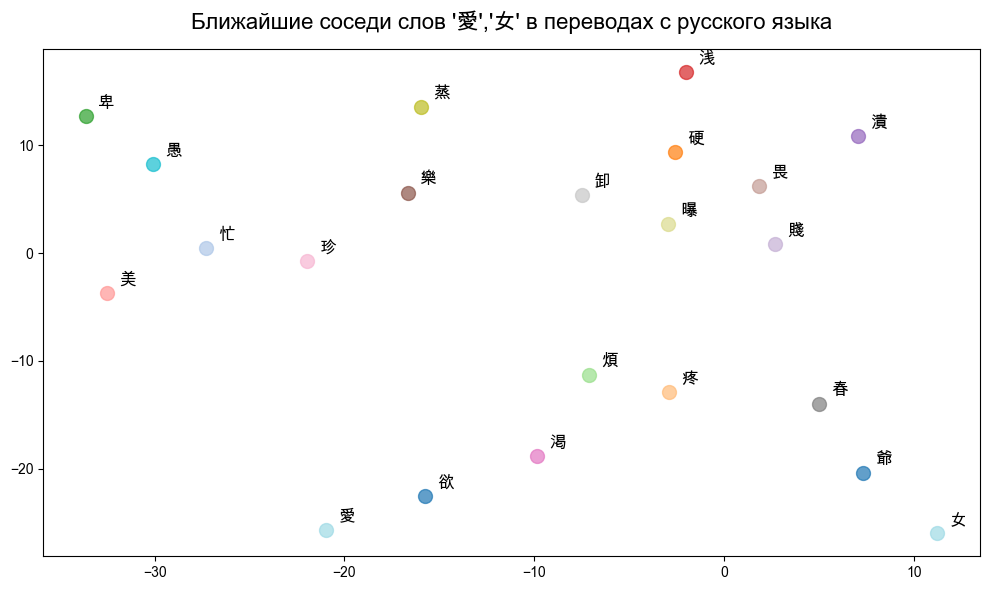

In [139]:
words = top_tr_love + ['愛','女']
vectors = [w2v_tr.wv[word] for word in words]
vectors = np.array(vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(np.array(vectors))
plt.figure(figsize=(10, 6))
texts = []
colors = plt.cm.tab20(np.linspace(0, 1, len(words)))
for i, word in enumerate(words): 
    plt.scatter(
        vectors_2d[i, 0], vectors_2d[i, 1], 
        c=[colors[i]], s=100, marker='o', 
        alpha=0.7
    )
    texts.append( 
        plt.text(
            vectors_2d[i, 0] + 0.5, vectors_2d[i, 1] + 0.5, 
            word, fontsize=12, fontfamily='Arial Unicode MS'
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)) #укладка и подрисовка стрелочек

plt.title("Ближайшие соседи слов '愛','女' в переводах с русского языка",
          fontsize=16, fontfamily='Arial Unicode MS', pad=15, weight='bold')
plt.tight_layout()
plt.show()

Для корпуса переводов характерно некое презрительно отношение: страсть (欲, ёку), боль (疼, ями), неприличность (春, сюн). Это разрушает (潰, цубусу), высушивает (渇, каваку), угрожает (畏, осорэру), досаждает (煩, вадзурау). Да, оно бывает красиво (美, уцукусии), радостно (樂, таносии) и необычно (珍, мэдзурасии), но в тоже самое время глупо (愚, орока) и подло (賤, сэмай) по сути своей.

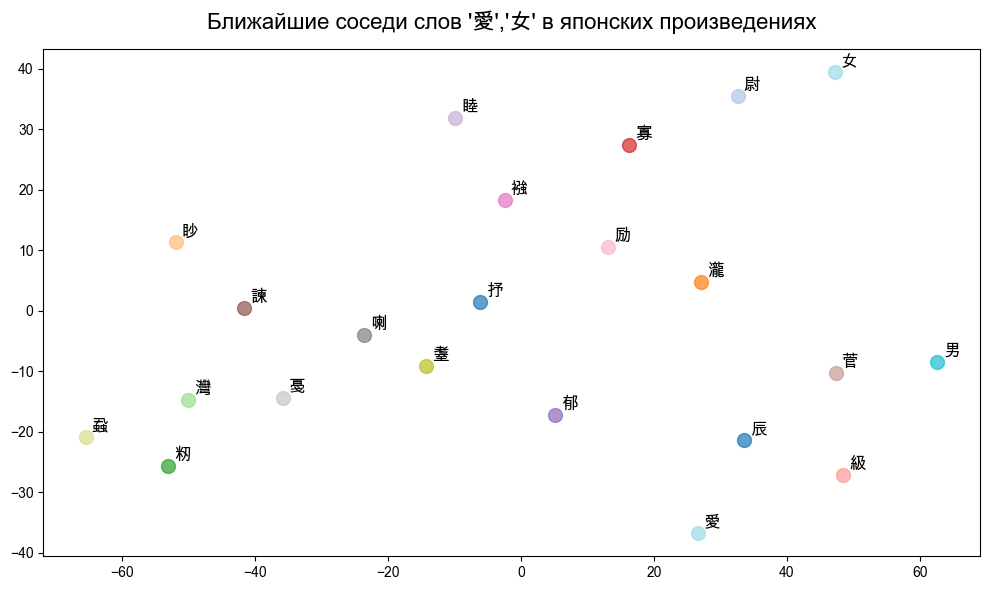

In [141]:
words = top_jp_love + ['愛','女']
vectors = [w2v_jp.wv[word] for word in words]
vectors = np.array(vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(np.array(vectors))
plt.figure(figsize=(10, 6))
texts = []
colors = plt.cm.tab20(np.linspace(0, 1, len(words)))
for i, word in enumerate(words): 
    plt.scatter(
        vectors_2d[i, 0], vectors_2d[i, 1], 
        c=[colors[i]], s=100, marker='o', 
        alpha=0.7
    )
    texts.append( 
        plt.text(
            vectors_2d[i, 0] + 0.5, vectors_2d[i, 1] + 0.5, 
            word, fontsize=12, fontfamily='Arial Unicode MS'
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)) #укладка и подрисовка стрелочек

plt.title("Ближайшие соседи слов '愛','女' в японских произведенияx",
          fontsize=16, fontfamily='Arial Unicode MS', pad=15, weight='bold')
plt.tight_layout()
plt.show()

Японские произведения настраивают нас на старинный лад: многие из визуализированных иероглифов редки в использовании и записаны на старый манер. К тому же, они отражают реалии "прошлой жизни": указание на месяцы и годы по лунному календарю (辰, тацу (дракон в лунном календаре); 睦/襁, муцуки (первый лунный месяц)), алебарда (戞, хоко), санновник (菅, кан). Действие часто ассоциируется с водными объектами, будь то водопад (瀧, таки) или залив (灣, ван). Проясняются также действующие лица: вдова (寡, ямомэ), пожилой (耋, тосиёри), мужчина (男, отоко), офицер (尉, и). Интересно, что именно здесь впервые в нашем анализе "любви" и "женщины" появляется "мужчина". Романтическая линия имеет социальную подоплеку, поскольку встречается слово "уровень"/"класс" (級, кю).

**Эмоциональный анализ**

Для японской литературы характерно описание чувств и чаяний героя. Можно посмотреть, насколько это отразится на эмоцианальности всего корпуса. Кроме того, интересно, какие эмоции - позитивные или негативные - будут присуще японским текстам по сравненинию с переводами с русского. Для этого создадим на основе полученного в результате лемматизации датафрейма строку, где все слова будут стоять в изначальной форме. После всего объединим в один список, который будем рассматривать.

In [160]:
tr_token = df_tr_clean.loc[:, ['token']]
corpus_tr_lem = []
for index, row in tr_token.iterrows():
    line = row['token']
    corpus_tr_lem.append(line)

corpus_tr_lem = ''.join(corpus_tr_lem)

In [163]:
jp_token = df_jap_clean.loc[:, ['token']]
corpus_jp_lem = []
for index, row in jp_token.iterrows():
    line = row['token']
    corpus_jp_lem.append(line)

corpus_jp_lem = ''.join(corpus_jp_lem)

In [164]:
corp = [corpus_tr_lem, corpus_jp_lem]

Существуют библиотеки, позволяющие проводить сентимент-анализ японских текстов автоматически. Например, oseti. Главная проблема - необходимо отслеживать зависимости и модули, потому что, как это часто бывает с японскими пакетами, они специфичны и не всегда обновляются. Чтобы сэкономить время (на самом деле, я несколько дней пытался настроить их работу, но ничего не получилось) возьмем из репозитория подобных проектов готовые списки с размеченной позитивной и негативной лексикой. В нашем случае, список существительных pn_noun.json в формате json. При открытии файла появиться словарь, в котором ключ - слово, а значение - оценка. Буква "р" - позитив (+), тогда как "n" - негатив (-). 

In [148]:
with open('pn_noun.json', 'r') as file:
    senti = json.load(file)

In [156]:
pos_lex = [k for k, v in senti.items() if v == 'p']
print(pos_lex[:10])
print(len(pos_lex))

['1位', '1周年記念', '1勝', '1番', 'ATフィールド', 'BIG', 'KO', 'あく抜け', 'あこがれ', 'あざやか']
3350


In [158]:
neg_lex = [k for k, v in senti.items() if v == 'n']
print(neg_lex[:10])
print(len(neg_lex))

['2次感染', '2失点', '3連敗', 'AIDS', 'A型肝炎', 'BOT', 'BSE', 'C型肝炎', 'DV', 'ED']
4958


Создадим функцию, которая подсчитает нам необходимые для последующих анализа и визуализации измерения.

In [165]:
def corpus_scorer_ed(corpus):
    neg_scores = []
    pos_scores = []
    diff_scores = []
    num_tokens = []
    num_pos = []
    num_neg = []
    for text in corpus:
        neg_score = 0
        pos_score = 0
        len_t = len(text)
        for token in text:
            if token in pos_lex:
               pos_score += 1
            elif token in neg_lex:
                neg_score += 1
        neg_scores.append(round(neg_score/len_t*100, 2)) 
        pos_scores.append(round(pos_score/len_t*100, 2)) 
        diff_scores.append(round(pos_score/len_t*100 - neg_score/len_t*100, 2)) 
        num_tokens.append(len_t)
        num_pos.append(pos_score)
        num_neg.append(neg_score)
    return {'pos_score': pos_scores, 'neg_score': neg_scores, 'pos_neg': diff_scores,
           'num_tokens': num_tokens, 'num_pos': num_pos, 'num_neg': num_neg}

In [166]:
scores = corpus_scorer_ed(corp)
scores

{'pos_score': [1.11, 1.4],
 'neg_score': [0.64, 0.73],
 'pos_neg': [0.47, 0.66],
 'num_tokens': [2321417, 2343429],
 'num_pos': [25878, 32720],
 'num_neg': [14858, 17193]}

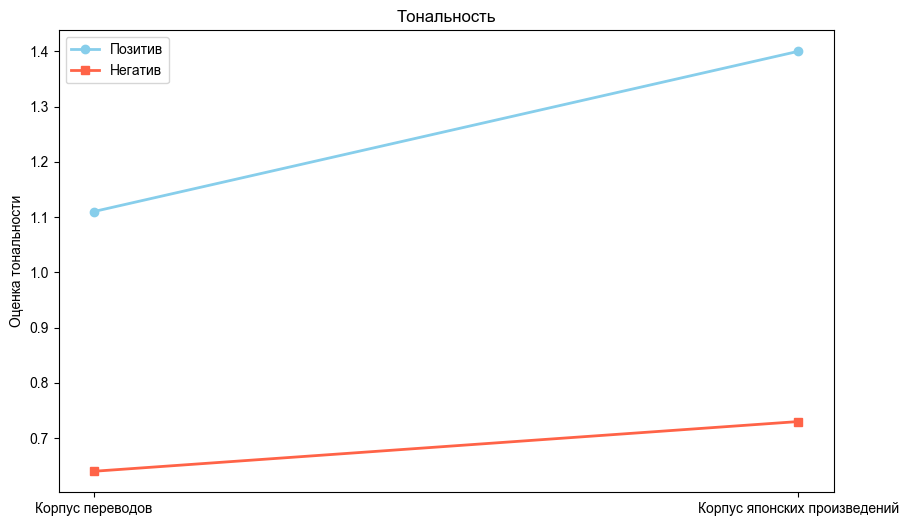

In [167]:
c = ['Корпус переводов', 'Корпус японских произведений']
plt.figure(figsize=(10, 6))
plt.plot(c, scores['pos_score'], label='Позитив', color='skyblue', marker='o', linewidth=2)
plt.plot(c, scores['neg_score'], label='Негатив', color='tomato', marker='s', linewidth=2)
plt.title('Тональность')
plt.ylabel('Оценка тональности')
plt.legend()

In [168]:
emotions = []
for index in range(len(scores['pos_score'])):
    emotions.append(scores['pos_score'][index] + scores['neg_score'][index])
print(emotions)

[1.75, 2.13]


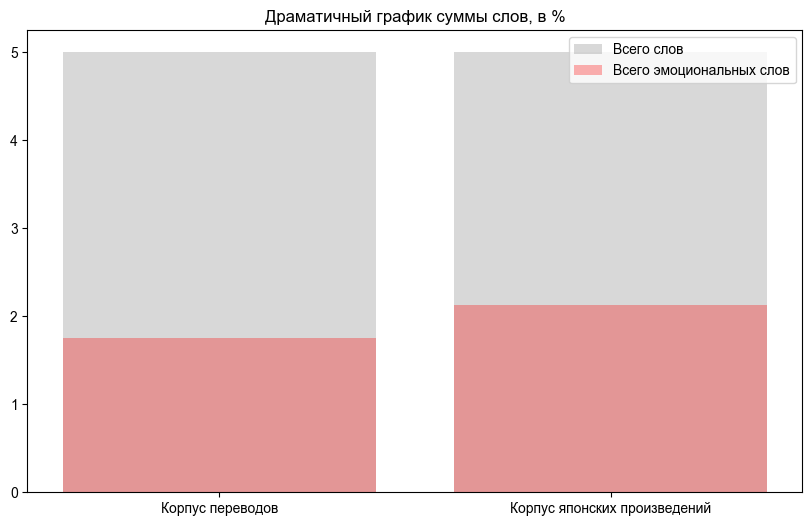

In [239]:
plt.figure(figsize=(10, 6))
plt.bar(c, 5, color='gray', label='Всего слов', alpha=0.3)
plt.bar(c, emotions, color='red', label='Всего эмоциональных слов', alpha=0.3)
plt.title('Драматичный график суммы слов, в %')
plt.legend()

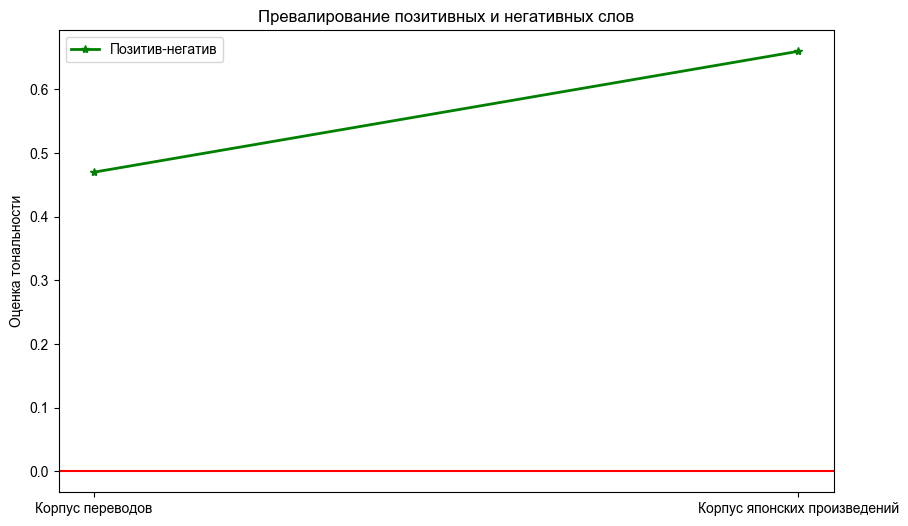

In [170]:
plt.figure(figsize=(10, 6))
plt.plot(c, scores['pos_neg'], label='Позитив-негатив', color='green', marker='*', linewidth=2)
plt.title('Превалирование позитивных и негативных слов')
plt.ylabel('Оценка тональности')
plt.legend()
plt.axhline(y=0, color='red', linestyle='-')

Японские тексты эмоциональнее, чем переводы. Оба корпуса больше позитивные, чем негативные. Однако, если визуализировать оценки тональностей в виде линейного графика, то увидим, что у позитивной линии наклон больше. Другими словами, переводы догоняют японские произведения по негативным оценкам. Японцы не так любят грустить, как русские)

Попробуем посмотреть тональности отедльных абстрактных понятий: "любовь" и "зло".

In [212]:
love = []
for text in corp:
    text_context = []
    for index in range(len(text)):
        if text[index] == '愛':  
            start = max(0, index - 5) 
            end = min(len(text), index + 5 + 1) 
            context = ' '.join(text[start:end])  
            text_context.append(context)
    love.append(' '.join(text_context))
        
evil = []
for text in corp:
    text_context = []
    for index in range(len(text)):
        if text[index] == '悪':  
            start = max(0, index - 5) 
            end = min(len(text), index + 5 + 1) 
            context = ' '.join(text[start:end])  
            text_context.append(context)
    evil.append(' '.join(text_context))

In [213]:
love_count = corpus_scorer_ed(love)
evil_count = corpus_scorer_ed(evil)

In [214]:
love_count

{'pos_score': [6.01, 6.42],
 'neg_score': [0.21, 0.17],
 'pos_neg': [5.8, 6.26],
 'num_tokens': [24771, 13793],
 'num_pos': [1488, 886],
 'num_neg': [51, 23]}

In [215]:
evil_count

{'pos_score': [0.55, 0.68],
 'neg_score': [6.1, 5.2],
 'pos_neg': [-5.56, -4.52],
 'num_tokens': [28005, 21053],
 'num_pos': [153, 143],
 'num_neg': [1709, 1094]}

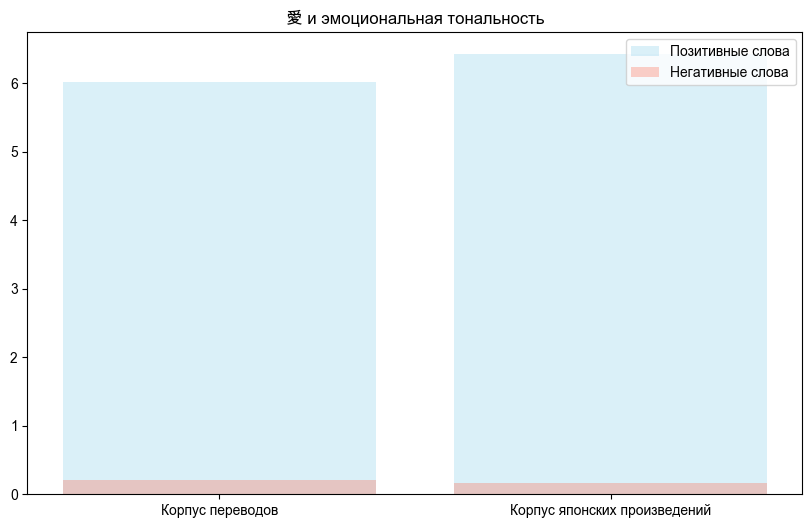

In [243]:
plt.figure(figsize=(10, 6))
plt.bar(c, love_count['pos_score'], color='skyblue', label='Позитивные слова', alpha=0.3)
plt.bar(c, love_count['neg_score'], color='tomato', label='Негативные слова', alpha=0.3)
plt.title('愛 и эмоциональная тональность')
plt.legend()

Японские тексты более позитивны, когда дела касаются "любви". В переводах русской литературы "любовь" более мрачна.

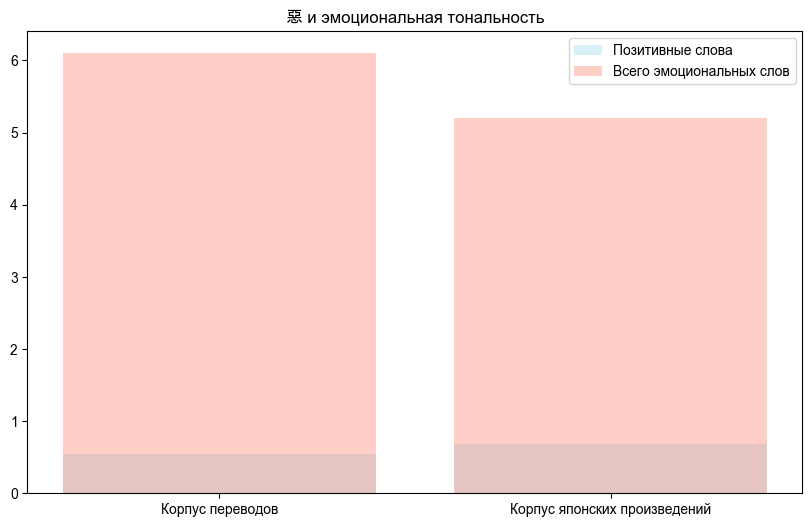

In [244]:
plt.figure(figsize=(10, 6))
plt.bar(c, evil_count['pos_score'], color='skyblue', label='Позитивные слова', alpha=0.3)
plt.bar(c, evil_count['neg_score'], color='tomato', label='Всего эмоциональных слов', alpha=0.3)
plt.title('惡 и эмоциональная тональность')
plt.legend()

Здесь картина, неожтданным образом, изменилась. Корпус переводов оказался более эмоциональным. "Зло" воспринимается в русских произведениях негативнее, чем в японских. На это, безусловно, оказало влияние христианство с твердыми разграничениями "добра" и "зла", тогда как в традиционной японской религии граница между ними менее заметна.

In [223]:
c_tm_tr = corpus_tr_lem.split(',')
c_tm_jp = corpus_jp_lem.split(',')

In [225]:
dictionary_tr = corpora.Dictionary([c_tm_tr])
dictionary_jp = corpora.Dictionary([c_tm_jp])

In [227]:
corp_tm_tr = [dictionary_tr.doc2bow(c_tm_tr)]
corp_tm_jp = [dictionary_jp.doc2bow(c_tm_jp)]

In [234]:
lda_model_tr = LdaModel(corp_tm_tr, num_topics=10, id2word=dictionary_tr, passes=10)

In [235]:
for idx, topic in lda_model_tr.print_topics(-1):
    print(f'Тема {idx}: {topic}')

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [236]:
np.exp2(-lda_model_tr.log_perplexity(corp_tm_tr))

4.9320104190466445

Выше была представлена неудачная попытка тематического моделирования. Решил оставить по одной весомой причине. В нынешнем виде функция LdaModel() не может обрабатывать японский текст. Она считывает весь текст в качестве одного слова и логично выделяет одну тему. На данный момент я не придумал соответствующий костыль, но, надеюсь, в течение лета смогу придумать решение этой задачки.

**Вместо заключения**

В рамках данной работы нам удалось рассмотреть с разных сторон два корпуса: корпус переводов русской литературы на японский язык и корпус японских произведений. Где-то есть небольшие пересечения, но, в целом, заметна оригинальность и непохожесть японской литературы на переводы. С одной стороны, это говорит нам о качестве этих самых переводов, которые отошли от пересказа "по мотивам" и стали отражать автора и реалии другой страны в иноязычной обстановке. С другой, несмотря на все изменения и вызовы японская литература не стала подражать образцам других литератур, а обратилось к собственной культуре, к своим корням. В каком-то смысле даже наоборот, в ней даже нашлось место для противостоянию механическому прогрессу и миру модерна. Определенные влияние есть, но семантически романы и повести японских авторов восходят к традиционным воззрениям и представлениям.

Другая цель состояла в том, чтобы опробовать изученные методы на новом для меня японском материале. Были созданы определённые костыли, позволяющие применить существующие библиотеки к японским реалиям (например, визуализация иероглифов и знаков фонетической азбуки), были рассмотрены особенности препроцессинга японских текстов и особенности лемматизации (вместе с возможными ошибками).